In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import levene
from scipy.stats import ttest_ind

# Prediction
1) Split the dataset into training and test sets before any major modeling decisions are made.
    - Determine the target variable and identify potential features of interest.
2) Feature engineering and feature selection.
    - Create or transform features in the dataset to improve its representational power.
    - Identify the most relevant features for the target variable.
3) Model exploration and model selection.
    - Experiment with different models using the training data and other validation methods to assess which model works best.

In [12]:
# Define target and features
target = 'Age'
features = ['G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
            '3P', '3PA', '3P%', '2P', '2PA', '2P%',
            'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
            'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
            'PTS', 'Year']

# Split the data into training and testing sets
X = nba[features]
Y = nba[target]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

kf = KFold(n_splits=5, shuffle=True)

In [13]:
linreg_model = LinearRegression()

mse_linreg, mae_linreg, r2_linreg = [], [], []

# Cross-Validation Loop
for train_index, test_index in kf.split(X_train):
    split_X_train, split_X_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    split_Y_train, split_Y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

    linreg_model.fit(split_X_train, split_Y_train)
    Y_pred_linreg = linreg_model.predict(split_X_test)

    mse_linreg.append(mean_squared_error(split_Y_test, Y_pred_linreg))
    mae_linreg.append(mean_absolute_error(split_Y_test, Y_pred_linreg))
    r2_linreg.append(r2_score(split_Y_test, Y_pred_linreg))

linreg_df = pd.DataFrame(
    {
        "feature_name": features,
        "coefficient" : linreg_model.coef_
    }
)

print(f"Linear Regression\nMSE: {np.mean(mse_linreg):.3f}, MAE: {np.mean(mae_linreg):.3f}, R²: {np.mean(r2_linreg):.3f}")
linreg_df.head()

Linear Regression
MSE: 15.369, MAE: 3.151, R²: 0.111


,feature_name,coefficient
0,G,-0.046500
1,GS,0.000548
2,MP,0.016496
3,FG,0.099054
4,FGA,2.008572


We moved up to an R-squared value of 0.108—our model explains only 10.8% of the variance in the dependent variable
(`Age`).
Let’s try a slightly different approach: LASSO regression, which performs feature selection and regularizairion.

In [14]:
lassocv_model = LassoCV(cv=5, max_iter=100_000)
lassocv_model.fit(X_train, Y_train)

best_alpha = lassocv_model.alpha_
print(f"Best Alpha Value: {best_alpha:.4f}")

Best Alpha Value: 0.0178


In [15]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_model = Lasso(alpha=0.0043)

mse_lasso, mae_lasso, r2_lasso = [], [], []

# Cross-validation loop
for train_index, test_index in kf.split(X_train):
    split_X_train, split_X_test = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    split_Y_train, split_Y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

    lasso_model.fit(split_X_train, split_Y_train)
    Y_pred_lasso = lasso_model.predict(split_X_test)

    mse_lasso.append(mean_squared_error(split_Y_test, Y_pred_lasso))
    mae_lasso.append(mean_absolute_error(split_Y_test, Y_pred_lasso))
    r2_lasso.append(r2_score(split_Y_test, Y_pred_lasso))

print(f"Lasso Regression\nMSE: {np.mean(mse_lasso):.3f}, MAE: {np.mean(mae_lasso):.3f}, R²: {np.mean(r2_lasso):.3f}")

Lasso Regression
MSE: 15.560, MAE: 3.175, R²: 0.099


/Users/logan/anaconda3/envs/dsci-lite/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.907e+01, tolerance: 2.232e+00
  model = cd_fast.enet_coordinate_descent(
/Users/logan/anaconda3/envs/dsci-lite/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.626e+02, tolerance: 2.200e+00
  model = cd_fast.enet_coordinate_descent(
/Users/logan/anaconda3/envs/dsci-lite/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()

rf_reg.fit(X_train, Y_train)

RandomForestRegressor()

In [18]:
from sklearn.metrics import r2_score, mean_absolute_error

preds = rf_reg.predict(X_test)
mse_rf = mean_squared_error(Y_test, preds)
r2_rf = r2_score(Y_test, preds)
mae_rf = mean_absolute_error(Y_test, preds)

print(f"Random Forest Regression\nMSE: {mse_rf:.3f}, MAE: {mae_rf:.3f}, R²: {r2_rf:.3f}")

Random Forest Regression
MSE: 12.364, MAE: 2.802, R²: 0.244


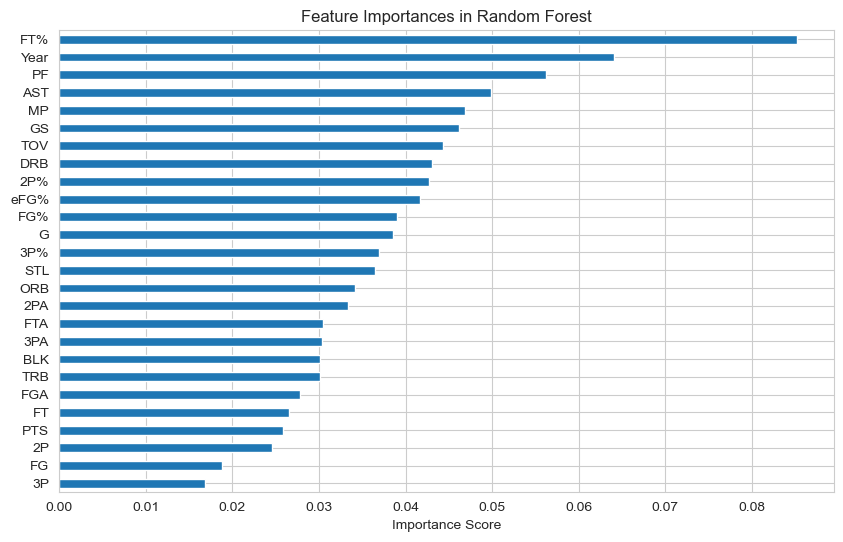

In [20]:
importances = rf_reg.feature_importances_
feature_names = X_train.columns
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title("Feature Importances in Random Forest")
plt.xlabel("Importance Score")
plt.show()

With the Random Forest model, we see a notable improvement in R-squared compared to our linear and Lasso regressions. This suggests the ensemble approach captures more complexity in the data.

The bar chart above indicates which features had the greatest impact on predicting `Age`. We see that **FT%** and **Year** top the list, followed by **PF** and **AST**.

Despite these improvements, we still have room for optimization. Future steps include:
1. **Hyperparameter Tuning** – Using techniques like GridSearchCV to find the best combination of parameters.
2. **Further Feature Engineering** – Investigating domain-specific transformations or additional variables that could boost predictive performance.
3. **Advanced Techniques** – Exploring other ensemble methods or deep learning approaches if suitable for the data size and problem scope.
